In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/BayesianPOLIMI

Mounted at /gdrive
/gdrive/My Drive/BayesianPOLIMI


In [ ]:
# Install cmdstanpy module
!pip install cmdstanpy

!pip list | grep cmdstanpy


cmdstanpy                          1.2.5


In [ ]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [ ]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpp__5w_oz
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [ ]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [ ]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Upload data




In [ ]:
y = pd.read_csv('TremorProb_1.csv')
print(y.head())

   -0.620922462937449  -0.668689165888089  -0.409872821087173  \
0           -0.620922           -0.668689           -0.409873   
1           -0.620922           -0.668689           -0.409873   
2           -0.620922           -0.668689           -0.409873   
3           -0.620922           -0.668689           -0.409873   
4           -0.620922           -0.668689           -0.409873   

   -0.46836544467914  -0.672098617117627  -0.568842619576277  \
0          -0.468365           -0.672099           -0.568843   
1          -0.468365           -0.672099           -0.568843   
2          -0.468365           -0.672099           -0.568843   
3          -0.468365           -0.672099           -0.568843   
4          -0.468365           -0.672099           -0.568843   

   -0.478079682575386  -0.417804016451204  -0.758451513461839  \
0            -0.47808           -0.417804           -0.758452   
1            -0.47808           -0.417804           -0.758452   
2            -0.47808        

In [ ]:
N = y.shape[0]
d = y.shape[1]
print("Dimension is", N)
print("Sample is", d)

Dimension is 287
Sample is 15


In [ ]:
x = np.linspace(0,1,N)

In [ ]:
y = np.array(np.transpose(y))

In [ ]:
y

array([[-0.62092246, -0.62092246, -0.62092246, ..., -0.62092246,
        -0.62092246, -0.62092246],
       [-0.66868917, -0.66868917, -0.66868917, ...,  0.59905107,
         0.25255206,  0.12731979],
       [-0.40987282, -0.40987282, -0.40987282, ..., -0.31308653,
        -0.35717438, -0.40126223],
       ...,
       [-0.4982822 , -0.4982822 , -0.4982822 , ..., -0.4982822 ,
        -0.4982822 , -0.4982822 ],
       [-0.6061394 , -0.6061394 , -0.6061394 , ..., -0.3327095 ,
        -0.43775713, -0.59682581],
       [-0.42226794, -0.42226794, -0.42226794, ..., -0.42226794,
        -0.42226794, -0.42226794]])

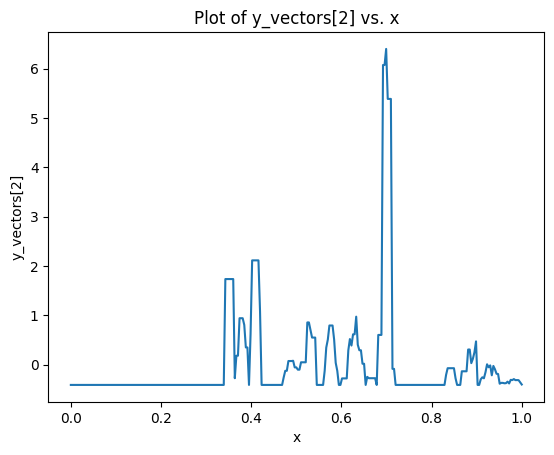

In [ ]:
plt.plot(x, y[2,:])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Current Model
This is the model we are going to use
$$
   \mathbf{y}{t}(s) = (1-\beta) \mu(s) + \beta \mathbf{y}{t-1}+ ϵ \in \mathbb{R}^{N}
$$

\\
Let $\mathbf{y}_{t}(s) = (Y(\mathbf{s}, t), \dots, Y(\mathbf{s}, t)) \in \mathbb{R}^{N}$. The hierarchical bayesian model is as follows

\\

\begin{aligned}
    \mathbf{y_t} \mid \beta, \mathbf{\mu}, \boldsymbol{\tau^2}, \mathbf{y_{t-1}} &\sim \text{multivariate normal}((1-\beta) \mu + \beta \mathbf{y}_{t-1}, diag(\tau^2))\\
    \mu &\sim \text{multivariate normal}(0,\sigma^2 \mathbf{A}(\rho))\\
    %\rho &\sim \text{InvGamma}(5, 5) \\
    \sigma &\sim \text{InvGamma}(1, 2) \\
    %\alpha &\sim \text{normal}(0, 1) \\
    \tau_i &\overset{\underset{\mathrm{i.i.d}}{}}{\sim} \text{InvGamma}(1, 2)  \    i=1,2...,N\\
    \beta &\sim \text{Beta}(1.5,1.5)
\end{aligned}

And
\begin{aligned}
 \mathbf{A}(\rho)_{ij} &= \frac{1}{(1-\rho^2)} \rho^{\lvert i-j \rvert}
 \end{aligned}

In [ ]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Temporal covariance kernel
matrix cov_time(int T, real rho_t) {
    matrix[T,T] cov;
    for (i in 1:T) {
        for(j in i:T) {
            cov[i,j] = rho_t^abs(i-j);
            cov[j,i] = cov[i,j];
        }
    }
    return (1/(1-rho_t^2)) * cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [ ]:
null_model_GP = """
        functions {
            matrix cov_time(int T, real rho_t) {
              matrix[T,T] cov;
              for (i in 1:T) {
                  for(j in i:T) {
                      cov[i,j] = rho_t^abs(i-j);
                      cov[j,i] = cov[i,j];
                  }
              }
              return (1/(1-rho_t^2)) * cov;
          }
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          vector[N] y0;
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          real<lower=0> rho;  // time innovation coefficient
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoreggresive vector
          array[d] vector[N] y_n_1;
          y_n_1[1] = y0;
          for (j in 2:d) {
            y_n_1[j] = Y[j - 1];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          vector[N] mu;

        }

        transformed parameters {
            // Mean vector
            //vector[N] media = (1-beta)*mu + beta*y_n_1;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = mu;
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);
        }

        generated quantities {
          vector[d] log_lik;
          for (j in 1:d) {
            log_lik[j] = multi_normal_lpdf(Y[j] | mu, diag_matrix(tau));
          }
        }

"""
# Write model to file
stan_file = "./stan/null_model_GP.stan"
with open(stan_file, "w") as f:
    print(null_model_GP, file=f)

# Compile stan model
null_model = CmdStanModel(stan_file=stan_file)

19:20:12 - cmdstanpy - INFO - compiling stan file /tmp/tmpkg5k5zzc/tmp3exr3bg3.stan to exe file /gdrive/My Drive/BayesianPOLIMI/stan/null_model_GP
INFO:cmdstanpy:compiling stan file /tmp/tmpkg5k5zzc/tmp3exr3bg3.stan to exe file /gdrive/My Drive/BayesianPOLIMI/stan/null_model_GP
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=null_model_GP.stan /tmp/tmpkg5k5zzc/tmp3exr3bg3
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=null_model_GP.stan --o=/tmp/tmpkg5k5zzc/tmp3exr3bg3.hpp /tmp/tmpkg5k5zzc/tmp3exr3bg3.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_

In [ ]:
y.shape

(15, 287)

In [ ]:
y0 = y[0,:] + np.random.normal(0,0.1,N)

In [ ]:
y0.shape

(287,)

In [ ]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "y0": y0,
    "rho": 0.3
}
#specify with the same names you put in data!

# Run the sampler
null_fit = null_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
null_data = az.from_cmdstanpy(null_fit)

DEBUG:cmdstanpy:cmd: /gdrive/My Drive/BayesianPOLIMI/stan/null_model_GP info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9vrnvou/ncdl5f6q.json
19:21:03 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/My Drive/BayesianPOLIMI/stan/null_model_GP', 'id=1', 'random', 'seed=40554', 'data', 'file=/tmp/tmpp9vrnvou/ncdl5f6q.json', 'output', 'file=/tmp/tmpp9vrnvou/null_model_GPwwkvm3sr/null_model_GP-20250117192104_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/My Drive/BayesianPOLIMI/stan/null_model_GP', 'id=4', 'random', 'seed=40554', 'data', 'file=/tmp/tmpp9vrnvou/ncdl5f6q.json', 'output', 'file=/tmp/tmpp9vrnvou/null_model_GPwwkvm3sr/null_model_GP-20250117192104_4.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/My Drive/BayesianPOLIMI/stan

19:50:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/My Drive/BayesianPOLIMI/stan/null_model_GP', 'id=1', 'random', 'seed=40554', 'data', 'file=/tmp/tmpp9vrnvou/ncdl5f6q.json', 'output', 'file=/tmp/tmpp9vrnvou/null_model_GPwwkvm3sr/null_model_GP-20250117192104_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpp9vrnvou/null_model_GPwwkvm3sr/null_model_GP-20250117192104_1.csv
 console_msgs (if any):
	/tmp/tmpp9vrnvou/null_model_GPwwkvm3sr/null_model_GP-20250117192104_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
    

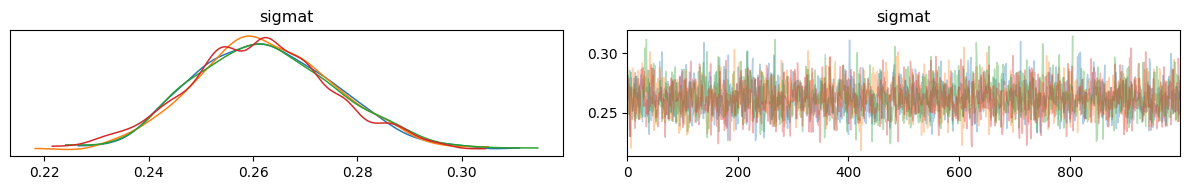

In [ ]:
az.plot_trace(null_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


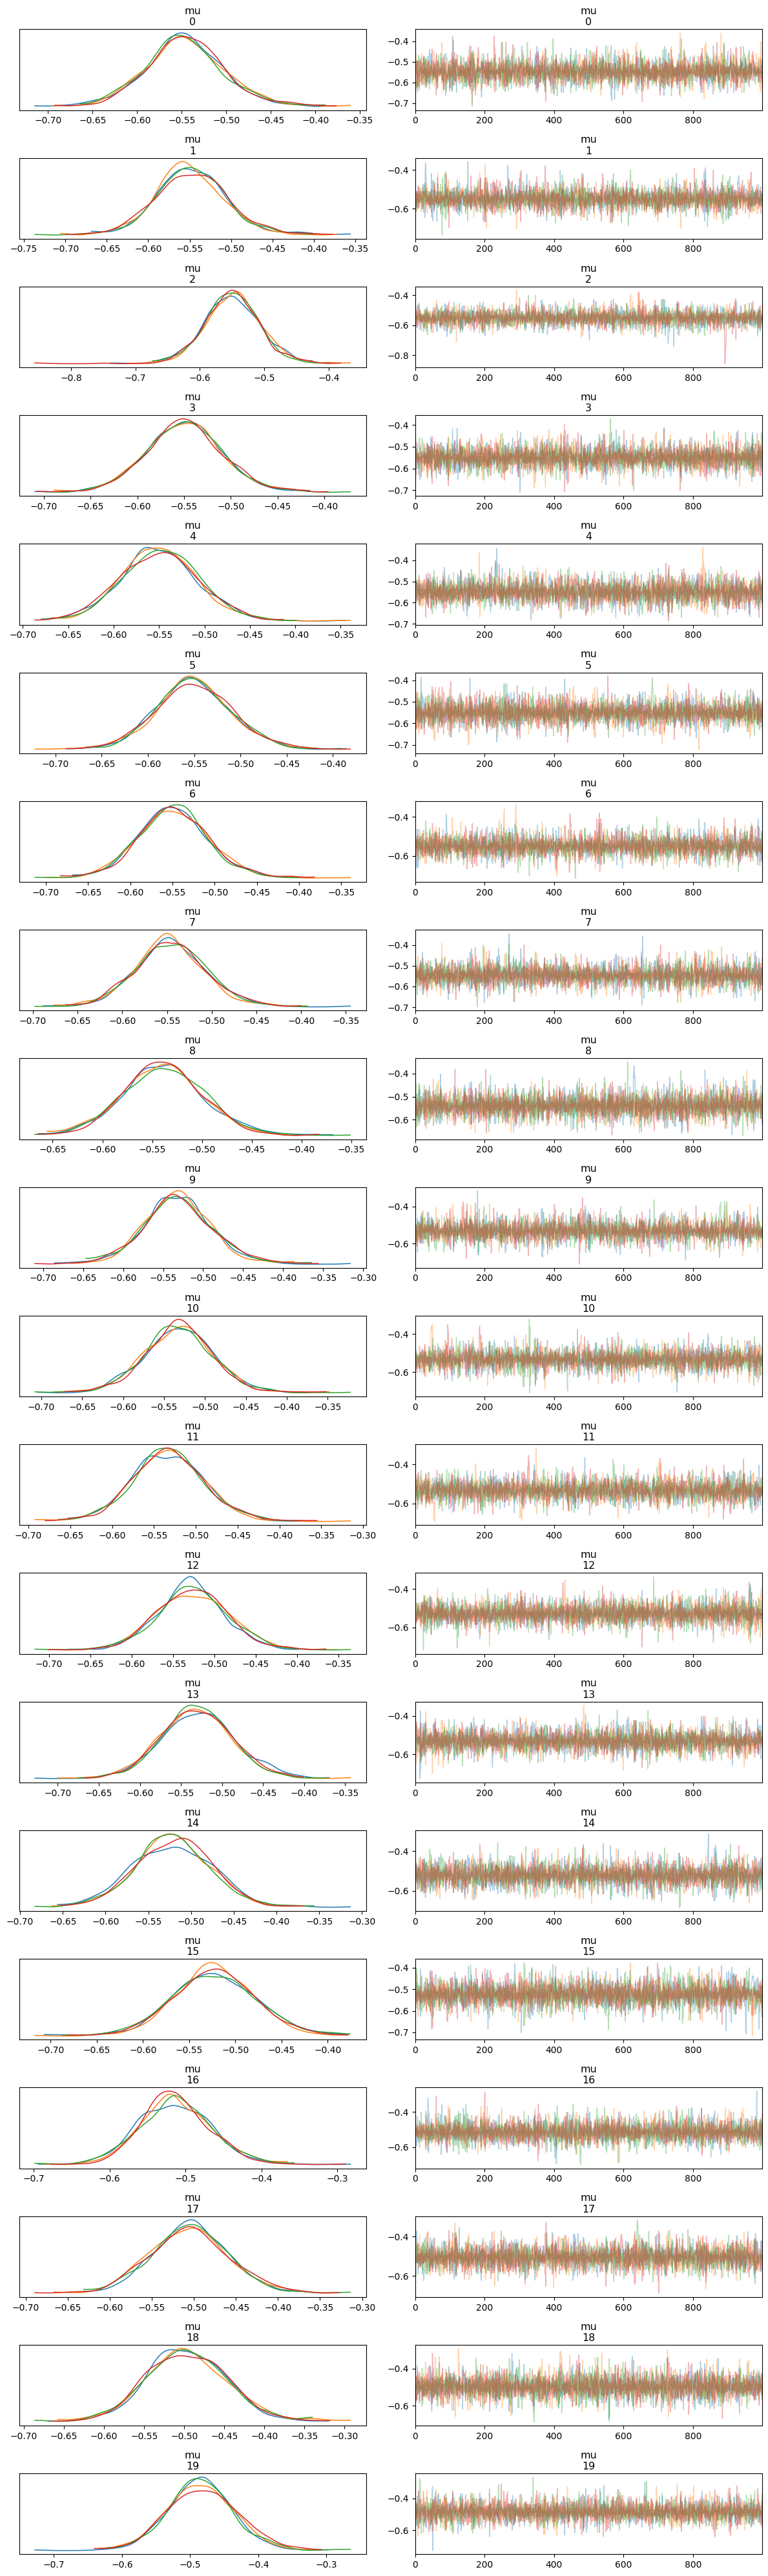

In [ ]:
az.plot_trace(null_data['posterior']['mu'], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
print("GLM-WAIC: ", az.waic(null_data, var_name="log_lik"))

GLM-WAIC:  Computed from 4000 posterior samples and 15 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4907.66    82.77
p_waic      279.69        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [ ]:
print("GLM-LOO: ", az.loo(null_data, var_name="log_lik"))

GLM-LOO:  Computed from 4000 posterior samples and 15 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4878.65    79.37
p_loo      250.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)   15  100.0%



/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [ ]:
null_log_lik = null_data.log_likelihood.log_lik

In [ ]:
log_marginal_lik_null = np.log(np.mean(np.exp(null_log_lik - np.max(null_log_lik)))) + np.max(null_log_lik)
log_marginal_lik_null

<xarray.DataArray 'log_lik' ()> Size: 8B
array(-284.24468313)

In [ ]:
np.save('log_marginal_lik_null.npy', log_marginal_lik_null)
#log_marginal_lik_null = np.load('log_marginal_lik_null.npy')

In [ ]:
synt4_fitGP_ML = """
        functions {
            matrix cov_time(int T, real rho_t) {
              matrix[T,T] cov;
              for (i in 1:T) {
                  for(j in i:T) {
                      cov[i,j] = rho_t^abs(i-j);
                      cov[j,i] = cov[i,j];
                  }
              }
              return (1/(1-rho_t^2)) * cov;
          }
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          vector[N] y0;
          real<lower=0> rho;  // time innovation coefficient
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoreggresive vector
          array[d] vector[N] y_n_1;
          y_n_1[1] = y0;
          for (j in 2:d) {
            y_n_1[j] = Y[j - 1];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          real<lower=0> beta;
          vector[N] mu;

        }

        transformed parameters {
            // Mean vector
            //vector[N] media = (1-beta)*mu + beta*y_n_1;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = (1 - beta) * mu + beta * y_n_1[i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);
          beta ~ beta(1.5,1.5);
        }

        generated quantities {
          vector[d] log_lik;
          for (j in 1:d) {
            vector[N] media = (1 - beta) * mu + beta * y_n_1[j];
            log_lik[j] = multi_normal_lpdf(Y[j] | media, diag_matrix(tau));
          }
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML
07:58:46 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --o=/gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML.hpp /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I sta

In [ ]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "y0": y0,
    "rho": 0.3
}

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
full_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnqrxyk5/22be5bun.json
08:16:01 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML', 'id=1', 'random', 'seed=99387', 'data', 'file=/tmp/tmpnnqrxyk5/22be5bun.json', 'output', 'file=/tmp/tmpnnqrxyk5/synt5GP_fitMLwdkky_um/synt5GP_fitML-20250118081601_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML', 'id=2', 'random', 'seed=99387', 'data', 'file=/tmp/tmpnnqrxyk5/22be5bun.json', 'output', 'file=/tmp/tmpnnqrxyk5/synt5GP_fitMLwdkky_um/synt5GP_fitML-20250118081601_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdSta

08:45:09 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/BayesianPOLIMI/stan/synt5GP_fitML', 'id=1', 'random', 'seed=99387', 'data', 'file=/tmp/tmpnnqrxyk5/22be5bun.json', 'output', 'file=/tmp/tmpnnqrxyk5/synt5GP_fitMLwdkky_um/synt5GP_fitML-20250118081601_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpnnqrxyk5/synt5GP_fitMLwdkky_um/synt5GP_fitML-20250118081601_1.csv
 console_msgs (if any):
	/tmp/tmpnnqrxyk5/synt5GP_fitMLwdkky_um/synt5GP_fitML-20250118081601_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
     

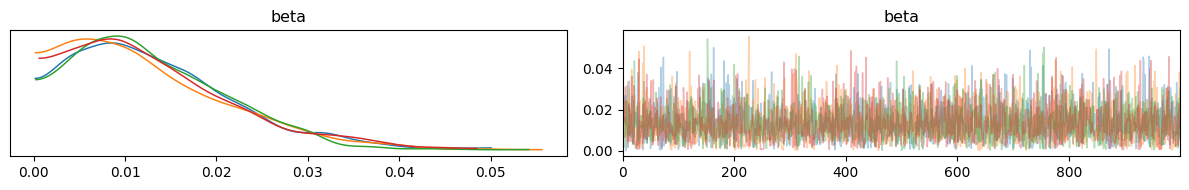

In [ ]:
az.plot_trace(full_data['posterior']['beta'], compact=False)
plt.tight_layout()
plt.show()

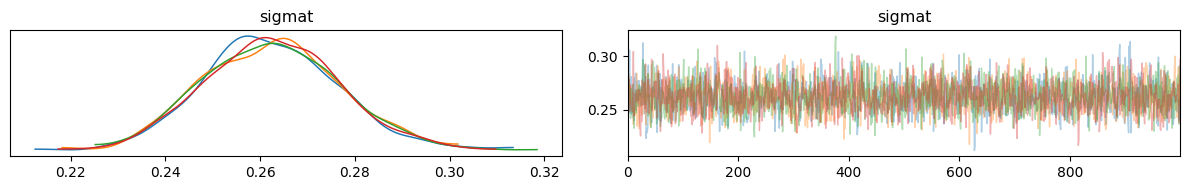

In [ ]:
az.plot_trace(full_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
list(full_data.posterior.data_vars)

['Lalpha', 'Sigma_t', 'beta', 'mu', 'sigmat', 'tau']

In [ ]:
print("full-WAIC: ", az.waic(full_data, var_name='log_lik'))
#print("null-WAIC: ", az.waic(full_data, var_name="log_lik_null"))

full-WAIC:  Computed from 4000 posterior samples and 15 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4920.58    80.58
p_waic      283.62        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [ ]:
print("GLM-LOO: ", az.loo(full_data, var_name="log_lik"))

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


GLM-LOO:  Computed from 4000 posterior samples and 15 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4882.25    76.82
p_loo      245.29        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)   15  100.0%



In [ ]:
full_log_lik = full_data.log_likelihood.log_lik

In [ ]:
log_marginal_lik_full = np.log(np.mean(np.exp(full_log_lik - np.max(full_log_lik)))) + np.max(full_log_lik)
log_marginal_lik_full

<xarray.DataArray 'log_lik' ()> Size: 8B
array(-286.29170783)

In [ ]:
np.save('log_marginal_lik_full.npy', log_marginal_lik_full)


In [ ]:
#log_marginal_lik_full = np.load('log_marginal_lik_full.npy')
log_marginal_lik_null = np.load('log_marginal_lik_null.npy')

In [ ]:
bayes_factor = np.exp(log_marginal_lik_null - log_marginal_lik_full)

print(f"Bayes Factor (BF_01): {bayes_factor}")

Bayes Factor (BF_01): <xarray.DataArray 'log_lik' ()> Size: 8B
array(7.74482361)


Note: [extension to glm gaussian process](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes) (not used in the project but interesting comunque)

Note for the future: [here to make predictions](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes)